In [4]:
import nbimporter 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import scipy.stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


# Data Prep

In [6]:
df=pd.read_csv("Train.csv") #Loading dataset into pandas

In [8]:
df=df.drop(columns=['id','CustomerId','Surname']) #Drop not useful columns

In [10]:
df=df.drop_duplicates(keep='first') #Drop duplicates

In [12]:
df.shape

(164911, 11)

In [14]:
#Onehot encoding categorical variable
encoder=OneHotEncoder(sparse_output=False)

en = encoder.fit_transform(df[['Geography','Gender']]) # = Categorical variables to be encoded

encoded_df = pd.DataFrame(en, columns=encoder.get_feature_names_out(['Geography', 'Gender']))#give name after encoding for easy identification

df_encoded = pd.concat([df.drop(['Geography', 'Gender'], axis=1), encoded_df], axis=1) #drop old and combine new columns into 1 df

In [16]:
#Scaling numerical features
scale_minmax= MinMaxScaler()
cols_to_scale=['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']
minmax_data = scale_minmax.fit_transform(df[cols_to_scale])
scaled_minmax_df = pd.DataFrame(minmax_data, columns=cols_to_scale)
df_processed_minmax= pd.concat([scaled_minmax_df, encoded_df, df[['HasCrCard','IsActiveMember','Exited']].reset_index(drop=True)], axis=1)

# Train AL

In [20]:
#Preparing data for machine algorithms
X= df_processed_minmax.drop('Exited', axis=1)
y= df_processed_minmax['Exited']

In [22]:
# Splitting train set into 3 parts

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# 0.25 x 0.8 = 0.2 --> 60% train, 20% val, 20% test

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Models initiated with params that may best fit  with this dataset - special consideration for class imbalance
models = {
    'LogReg': LogisticRegression(class_weight='balanced',solver='liblinear', max_iter=1000, C=1.0, random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=42,
                                           min_samples_split=20, min_samples_leaf=10),
    'HGB': HistGradientBoostingClassifier(class_weight='balanced', max_iter=100, max_depth=5, learning_rate=0.05,random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5, 
                                            min_samples_split=20, min_samples_leaf=10),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

#Get metric scores for each classifier
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(f"=== {name} ===")
    print(classification_report(y_val, preds))


=== LogReg ===
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     26065
           1       0.45      0.73      0.55      6917

    accuracy                           0.75     32982
   macro avg       0.68      0.75      0.69     32982
weighted avg       0.82      0.75      0.77     32982

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     26065
           1       0.54      0.78      0.64      6917

    accuracy                           0.82     32982
   macro avg       0.74      0.80      0.76     32982
weighted avg       0.85      0.82      0.83     32982

=== HGB ===
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     26065
           1       0.54      0.79      0.64      6917

    accuracy                           0.81     32982
   macro avg       0.74      0.80      0.76     32982
weighted avg       0.85   

In [38]:
#Put performance results in a nicer format 

from IPython.display import display, HTML
import tabulate

table= list()

for name,model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_val)
    else:
        y_scores = preds 

    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # use report and get metrics from it
    report = classification_report(y_val, preds, output_dict=True)
    accuracy = report['accuracy']
    f1= report['weighted avg']['f1-score']
    precision= report['1']['precision']
    recall= report['1']['recall']
    
    # Append results to the table
    table.append([name, accuracy, f1, precision, recall, roc_auc])

#display nice table format
html_table = tabulate.tabulate(table, headers=["Classifier", "Accuracy", "F1", "Precision", "Recall", "AUC Score"], tablefmt='html')
display(html_table)

Classifier,Accuracy,F1,Precision,Recall,AUC Score
LogReg,0.752835,0.771438,0.4458,0.734278,0.818223
RandomForest,0.817082,0.827643,0.544846,0.776348,0.883747
HGB,0.813565,0.824983,0.537952,0.786902,0.88702
Decision Tree,0.813838,0.824218,0.53999,0.758421,0.871243
K-Nearest Neighbors,0.844127,0.835958,0.668629,0.509036,0.819269


Fitting LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')
Done fitting
Predicting LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')
Done predicting.
Evaluating LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')
Done evaluating
Fitting RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)
Done fitting
Predicting RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)
Done predicting.
Evaluating RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)
Done evaluating

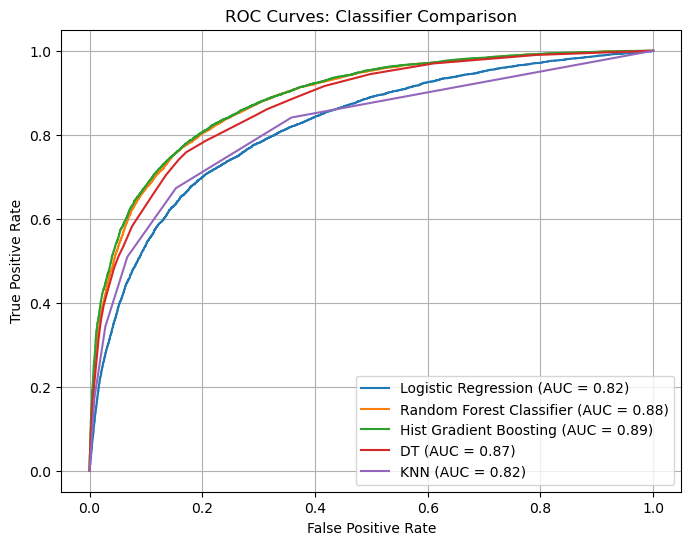

In [97]:
#Compare performance of each classifier 

def compare_classifier(classifier, x_train, y_train, x_val_test, y_val_test):
    try:
        # Fitting the classifier
        print(f"Fitting {classifier}")
        classifier.fit(x_train, y_train)
        print("Done fitting")

        # Predicting probabilities or decision function
        print(f"Predicting {classifier}")
        if hasattr(classifier, "predict_proba"):
            y_scores = classifier.predict_proba(x_val_test)[:, 1] 
        elif hasattr(classifier, "decision_function"):
            y_scores = classifier.decision_function(x_val_test)
        else:
            raise AttributeError("Classifier lacks both predict_proba and decision_function.")
        print("Done predicting.")

        # Evaluate performance
        print(f"Evaluating {classifier}")
        fpr, tpr, _ = roc_curve(y_val_test, y_scores)
        roc_auc = auc(fpr, tpr)
        print("Done evaluating")


        return fpr, tpr, roc_auc

    except Exception as e:
        print(f"Error with classifier {classifier.__class__.__name__}: {e}")
        return [0], [0], 0  # Return default values in case of error

#Setting up classifier
clf1=LogisticRegression(class_weight='balanced',solver='liblinear', max_iter=1000, C=1.0, random_state=42)
clf2=RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=42,
                                           min_samples_split=20, min_samples_leaf=10)
clf3= HistGradientBoostingClassifier(class_weight='balanced', max_iter=100, max_depth=5, learning_rate=0.05,random_state=42)
clf4= DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5, 
                                            min_samples_split=20, min_samples_leaf=10)
clf5= KNeighborsClassifier(n_neighbors=5)


#using classifiers
fpr1, tpr1, roc_auc1 = compare_classifier(clf1, X_train, y_train, X_val, y_val)
fpr2, tpr2, roc_auc2 = compare_classifier(clf2, X_train, y_train, X_val, y_val)
fpr3, tpr3, roc_auc3 = compare_classifier(clf3, X_train, y_train, X_val, y_val)
fpr4, tpr4, roc_auc4 = compare_classifier(clf4, X_train, y_train, X_val, y_val)
fpr5, tpr5, roc_auc5 = compare_classifier(clf5, X_train, y_train, X_val, y_val)

# Plotting
plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, label='Logistic Regression (AUC = %.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Random Forest Classifier (AUC = %.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Hist Gradient Boosting (AUC = %.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='DT (AUC = %.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='KNN (AUC = %0.2f)' % roc_auc5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Classifier Comparison')
plt.legend()
plt.grid()
plt.show()

In [98]:
# Cross validation check to ensure results aren't biased

for name, model in models.items():
    
    score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    
    print(f" {name} Cross-validation scores:", score)
    print("Average score:", score.mean())

 LogReg Cross-validation scores: [0.82206483 0.81823892 0.81905689 0.81942252 0.81491584]
Average score: 0.8187398006183988
 RandomForest Cross-validation scores: [0.8889035  0.88366281 0.8863291  0.88531567 0.88480061]
Average score: 0.8858023368428505
 HGB Cross-validation scores: [0.89169171 0.88667312 0.8893007  0.88789712 0.88817772]
Average score: 0.8887480723447881
 Decision Tree Cross-validation scores: [0.87423406 0.8692326  0.87235157 0.87294527 0.8728536 ]
Average score: 0.8723234207001571
 K-Nearest Neighbors Cross-validation scores: [0.82381411 0.81973705 0.82144625 0.81976698 0.82238754]
Average score: 0.8214303855064735


<b> HistGradientBoost seem to perform better than the rest

In [153]:
#Some more tuning for HGB

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'class_weight': ['balanced', None],   #for class imbalance
    'learning_rate': uniform(0.01, 0.3),  # Controls step size
    'max_iter': randint(100, 700),        # Number of boosting iterations
    'max_leaf_nodes': randint(1, 100),    # Max number of leaves per tree
    'min_samples_leaf': randint(10, 100), # Min samples at leaf node
    'l2_regularization': uniform(0.0, 20.0), # Regularization term
    'max_depth': [None, 3, 5, 10, 20],    # For depth restriction
    'early_stopping': [True, False],      # Early stopping based on validation score
    'scoring': ['loss', 'accuracy', 'roc_auc']
}


hgb = HistGradientBoostingClassifier(random_state=42)

#Randommized search with cross validation(5 times)
search = RandomizedSearchCV(hgb, param_distributions=param_dist, n_iter=30, scoring='roc_auc',
                            cv=5, n_jobs=-1, verbose=1, random_state=42)


search.fit(X_train, y_train)

# Get best results
print("Best Parameters:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'class_weight': 'balanced', 'early_stopping': False, 'l2_regularization': 6.519178104037695, 'learning_rate': 0.07607231426966449, 'max_depth': 3, 'max_iter': 610, 'max_leaf_nodes': 19, 'min_samples_leaf': 29, 'scoring': 'roc_auc'}
Best ROC AUC: 0.8890242577751621


# Test

Fitting HistGradientBoostingClassifier(class_weight='balanced', early_stopping=False,
                               l2_regularization=6.5, learning_rate=0.076,
                               max_depth=3, max_iter=610, max_leaf_nodes=19,
                               min_samples_leaf=29, random_state=42)
Done fitting
Predicting HistGradientBoostingClassifier(class_weight='balanced', early_stopping=False,
                               l2_regularization=6.5, learning_rate=0.076,
                               max_depth=3, max_iter=610, max_leaf_nodes=19,
                               min_samples_leaf=29, random_state=42)
Done predicting.
Evaluating HistGradientBoostingClassifier(class_weight='balanced', early_stopping=False,
                               l2_regularization=6.5, learning_rate=0.076,
                               max_depth=3, max_iter=610, max_leaf_nodes=19,
                               min_samples_leaf=29, random_state=42)
Done evaluating


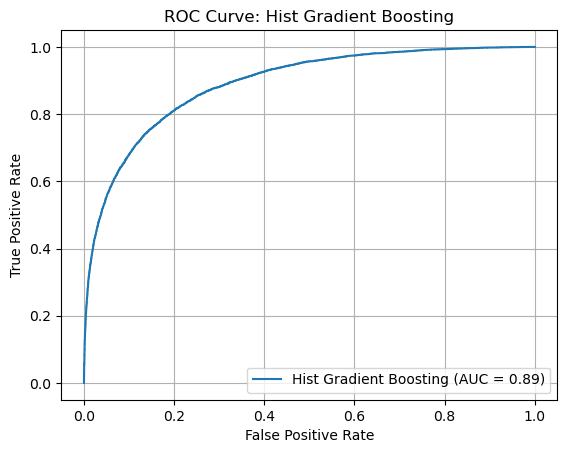

In [160]:
#Evaluating HistGradientBoost's performance on test sub-dataset using tuned parameters

clf= HistGradientBoostingClassifier(class_weight='balanced', max_iter=610, max_depth=3, learning_rate=0.076, l2_regularization=6.5, 
                                    max_leaf_nodes=19, min_samples_leaf=29, early_stopping=False, random_state=42)

FPR, TPR, AUC = compare_classifier(clf, X_train, y_train, X_test, y_test)

# ROC Curve
plt.plot(FPR, TPR, label='Hist Gradient Boosting (AUC = %.2f)' % AUC)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Hist Gradient Boosting')
plt.legend()
plt.grid()

In [162]:
score = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

print(" HGB Cross-validation scores:", score)
print("Average score:", score.mean())

 HGB Cross-validation scores: [0.89205045 0.88752212 0.88971706 0.88928003 0.88917253]
Average score: 0.889548439379196
